## Document-based Question-Answering system using LangChain and Pinecone

- LangChain is a powerful framework designed for developing applications driven by language models, while Pinecone serves as an efficient vector database for building high-performance vector search applications. 
- This use case focuses on answering questions over specific documents, relying solely on the information within those documents to generate accurate and context-aware answers -- basically it leverages the reasoning capabilities of LLMs while the knowledge base is ours so as to generate more context-specific and precise answers by grounding answers in specific passages from relevant documents.



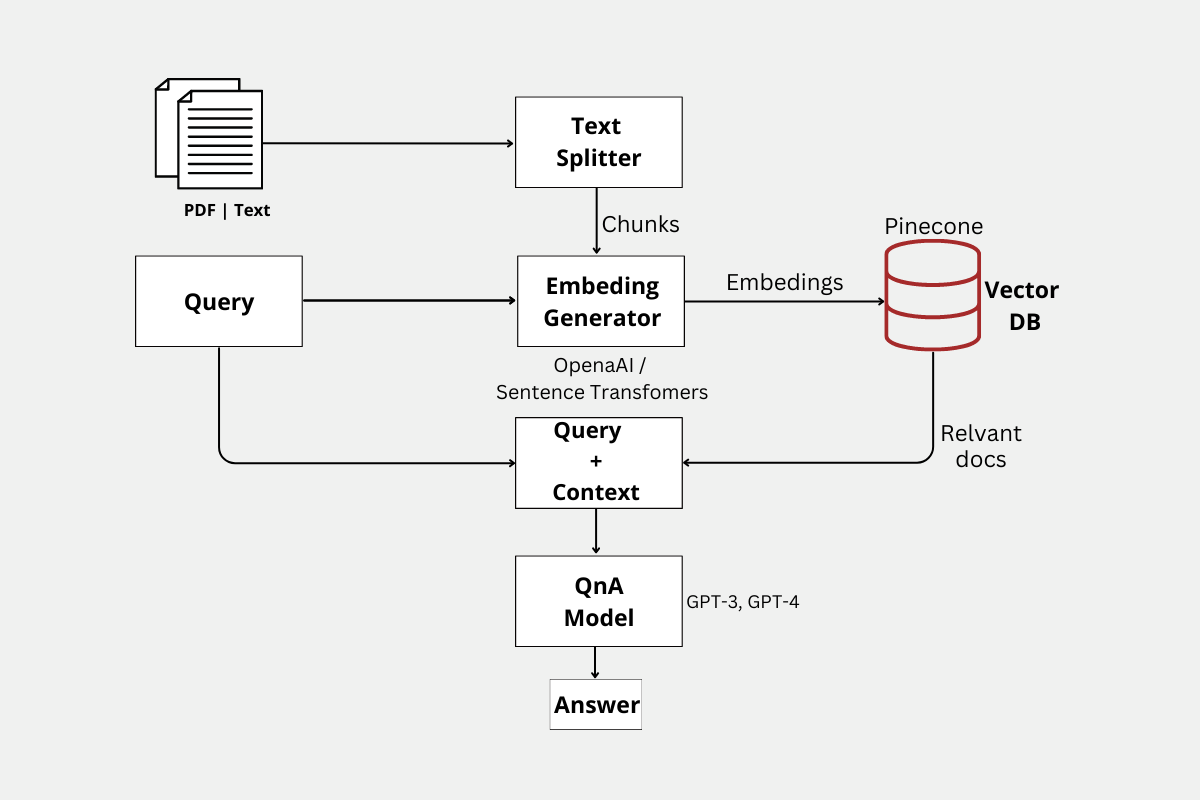

In [1]:
# !pip install langchain openai 
# !pip install unstructured 
# !pip install unstructured[local-inference] 
# !pip install detectron2@git+https://github.com/facebookresearch/detectron2.git   
# !pip install poppler-utils
# !pip install tiktoken
# !pip install pinecone-client

In [10]:
import os
import time
import openai
import pinecone      

from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.vectorstores import Pinecone
from langchain.chains.question_answering import load_qa_chain

In [4]:
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = ""

pinecone_apikey = ''
pinecone_env = '' 

## Load Documents

In [5]:
def load_documents(directory):
    loader = DirectoryLoader(directory)
    documents = loader.load()
    return documents

documents = load_documents('./data')
len(documents)

2

## Split Documents

In [6]:
def split_documents(documents, chunk_size=1000, chunk_overlap=20):
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    docs = splitter.split_documents(documents)
    return docs

docs = split_documents(documents)
print(len(docs))

28


In [40]:
docs[0].metadata['source']

'data\\India.pdf'

In [7]:
print(docs[0].page_content)

CAPE India, Supplementary Linked Document 2

INDIA: COUNTRY CONTEXT

A. Main Features of the Economy

1. India is the world’s second most populous country with a population of 1.27 billion in 2015 and the world’s third largest economy in purchasing power parity (PPP) terms.1 More than 50% of India’s population is currently below the age of 25, and more than 12 million people enter the labor market every year. By 2030, India is expected to have the largest labor force in the world. At more than 1 billion people of working age, India’s labor force will be larger than the combined labor forces of the United States, the eurozone, and Indonesia. India’s share of the world gross domestic product (GDP) has increased substantially from an average of 4.8% during 2001–2007 to an average of 7.0% during 2014–2015 in current PPP terms.2 Its GDP per capita using market prices and exchange rates rose to $1,584 in 2015 or $6,261 on PPP basis.3


## Embedding documents with OpenAI

In [12]:
embeddings_gen = OpenAIEmbeddings(model = 'text-embedding-ada-002')

query_result = embeddings_gen.embed_query('Hello World')
len(query_result)

1536

## Vector Store with Pinecone

In [15]:
# Return VectorStore initialized from documents and embeddings
# The Pinecone.from_documents() the method processes the input documents, generates embeddings using the provided OpenAIEmbeddings instance, and creates a new Pinecone index with the specified name. 
# The resulting index object can perform similarity searches and retrieve relevant documents based on user queries.

pinecone.init(      
    api_key = pinecone_apikey,      
    environment = pinecone_env     
) 

# index_name = pinecone.Index('langchain-demo')
index_store = Pinecone.from_documents(docs , embeddings_gen , index_name = 'langchain-demo')

## Finding similar documents

In [21]:
def get_similiar_docs(query , k=2 , score=False):
    if score:
        similar_docs = index_store.similarity_search_with_score(query,k=k)
    else:
        similar_docs = index_store.similarity_search(query,k=k)
    return similar_docs

In [22]:
query = "How is india's economy"
similar_docs = get_similiar_docs(query, score=True)
similar_docs

[(Document(page_content='CAPE India, Supplementary Linked Document 2\n\nINDIA: COUNTRY CONTEXT\n\nA. Main Features of the Economy\n\n1. India is the world’s second most populous country with a population of 1.27 billion in 2015 and the world’s third largest economy in purchasing power parity (PPP) terms.1 More than 50% of India’s population is currently below the age of 25, and more than 12 million people enter the labor market every year. By 2030, India is expected to have the largest labor force in the world. At more than 1 billion people of working age, India’s labor force will be larger than the combined labor forces of the United States, the eurozone, and Indonesia. India’s share of the world gross domestic product (GDP) has increased substantially from an average of 4.8% during 2001–2007 to an average of 7.0% during 2014–2015 in current PPP terms.2 Its GDP per capita using market prices and exchange rates rose to $1,584 in 2015 or $6,261 on PPP basis.3', metadata={'source': 'data

## Question answering using LangChain and OpenAI LLM

In [31]:
llm = OpenAI(model = 'text-davinci-003')
chain = load_qa_chain(llm = llm)

def get_answer(query):
    '''
    For a given query, do a semantic search over document embeddings and return K similar documents.
    These serve as my knowledge base for the query and then using any LLM model return answer for the query.
    '''
    similar_docs = get_similiar_docs(query)
    answer = chain.run(input_documents = similar_docs , question = query)
    return similar_docs , answer

In [32]:
query = "How is India's economy?"
answer = get_answer(query)
print(answer[1].strip())

India's economy is the world's third largest in purchasing power parity (PPP) terms and is expected to have the largest labor force in the world by 2030. The services sector, particularly distribution, transport, communication, and finance, have grown rapidly and accounted for 54% of GDP in FY2015. India is an important player in the global IT industry, and is a leader in the use of IT for e-government and the delivery of services. Its GDP per capita using market prices and exchange rates rose to $1,584 in 2015 or $6,261 on PPP basis.


In [33]:
print(answer[0])

[Document(page_content='CAPE India, Supplementary Linked Document 2\n\nINDIA: COUNTRY CONTEXT\n\nA. Main Features of the Economy\n\n1. India is the world’s second most populous country with a population of 1.27 billion in 2015 and the world’s third largest economy in purchasing power parity (PPP) terms.1 More than 50% of India’s population is currently below the age of 25, and more than 12 million people enter the labor market every year. By 2030, India is expected to have the largest labor force in the world. At more than 1 billion people of working age, India’s labor force will be larger than the combined labor forces of the United States, the eurozone, and Indonesia. India’s share of the world gross domestic product (GDP) has increased substantially from an average of 4.8% during 2001–2007 to an average of 7.0% during 2014–2015 in current PPP terms.2 Its GDP per capita using market prices and exchange rates rose to $1,584 in 2015 or $6,261 on PPP basis.3', metadata={'source': 'data\

In [34]:
query = "How have relations between India and the US improved?"
answer = get_answer(query)
print(answer[1].strip())

Relations between India and the US have improved due to increased bilateral trade. According to the provisional data of the Commerce Ministry, the bilateral trade between India and the U.S. has increased by 7.65% to $128.55 billion in 2022-23 as compared to $119.5 billion in 2021-22, and exports to the US rose by 2.81% to $78.31 billion in 2022-23 as compared to $76.18 billion in 2021-22.


In [35]:
print(answer[0])

[Document(page_content='Experts believe that the trend of increasing bilateral trade with the U.S. will continue in the coming years also as New Delhi and Washington are engaged in further strengthening the economic ties.', metadata={'source': 'data\\India_US.txt'}), Document(page_content="The U.S. has emerged as India's biggest trading partner in 2022-23 on account of increasing economic ties between the two countries. According to the provisional data of the Commerce Ministry, the bilateral trade between India and the U.S. has increased by 7.65% to $128.55 in 2022-23 as against $119.5 billion in 2021-22. It was $80.51 billion in 2020-21. Exports to the U.S. rose by 2.81% to $78.31 billion in 2022-23 as against $76.18 billion in 2021-22, while imports grew by about 16% to $50.24 billion, the data showed. The U.S. has emerged as India's biggest trading partner in 2022-23 on account of increasing economic ties between the two countries. According to the provisional data of the Commerce 